# TrainBaseModel.ipynb

This notebook trains a baseline convolutional neural network (CNN) to classify images from a 5-class subset of the Fruits 360 dataset.  
The model will be saved for comparison with future models using data augmentation and transfer learning.


In [ ]:
from google.colab import files
#files.upload()  # Upload fruit_subset_100.zip again


In [3]:
import zipfile

with zipfile.ZipFile("fruit_subset_100.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fruit_subset_100")


In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/fruit_subset_100",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/fruit_subset_100",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


## Define Baseline CNN Model

We use a simple convolutional model with two convolutional layers and one dense output layer.


In [15]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3699 - loss: 1566.3564 - val_accuracy: 0.6400 - val_loss: 10.9733
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8410 - loss: 4.6169 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9913 - loss: 0.1335 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9918 - loss: 0.4045 - val_accuracy: 0.9300 - val_loss: 2.5658
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9703 - loss: 2.8478 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9993 - loss: 0.0304 - val_accuracy: 0.7800 - val_loss: 31.0117
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9446 - loss: 6.3259 - val_accuracy: 0.7800 - val_loss: 14.5172
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9676 - loss: 2.6195 - val_accuracy: 

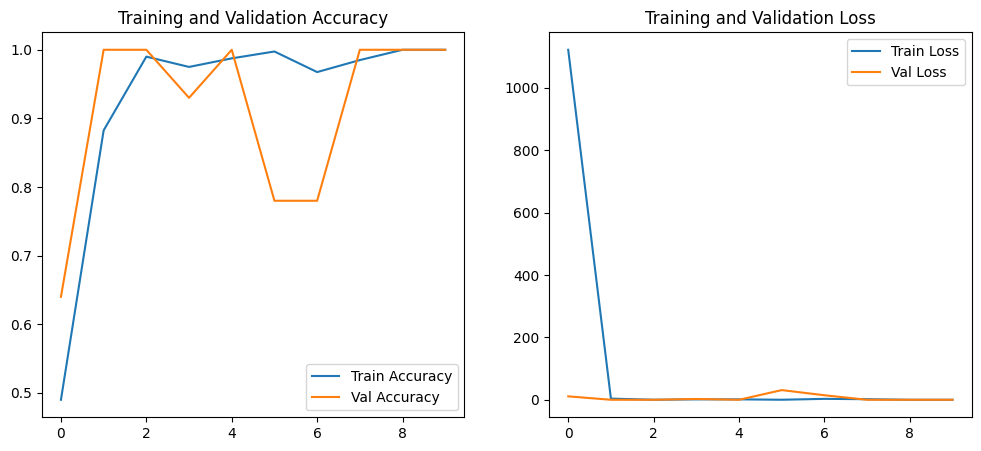

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


## ResNet50 as a Base Model

In [19]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "/content/fruit_subset_100"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)


Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [20]:
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the pretrained part


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Replace with your number of classes
])


In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - accuracy: 0.1975 - loss: 1.9494 - val_accuracy: 0.2000 - val_loss: 1.5708
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.2226 - loss: 1.6076 - val_accuracy: 0.4600 - val_loss: 1.5004
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.4123 - loss: 1.4842 - val_accuracy: 0.6500 - val_loss: 1.4020
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.7733 - loss: 1.3788 - val_accuracy: 0.8100 - val_loss: 1.2957
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.8161 - loss: 1.3010 - val_accuracy: 0.7300 - val_loss: 1.2173
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.7974 - loss: 1.2090 - val_accuracy: 0.8800 - val_loss: 1.1305
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.8671 - loss: 1.1249 - val_accuracy: 0.6500 - val_loss: 1.0721
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.7420 - loss: 1.0698 - val_accuracy: 0.8900 - val_l

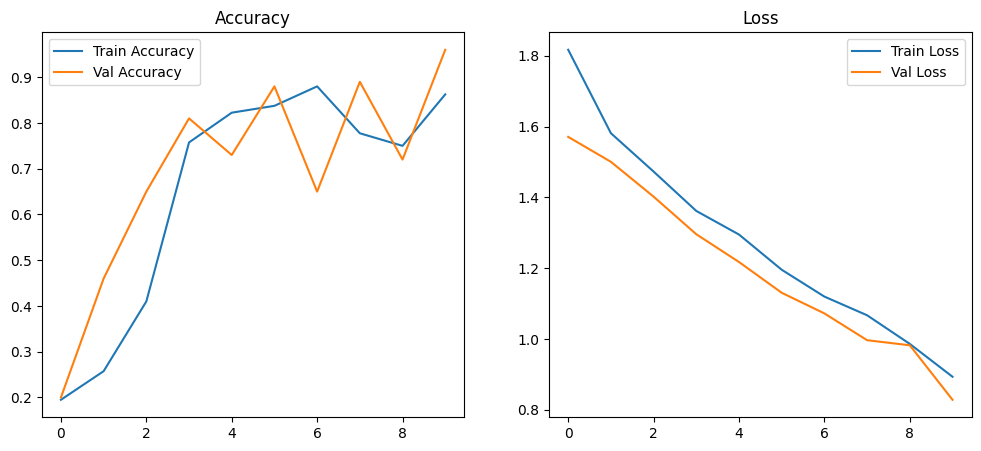

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


## **Base Model Conclusion**
While the custom CNN showed perfect training and validation accuracy, its performance likely resulted from overfitting or memorizing the small dataset. In contrast, ResNet50 demonstrated realistic learning curves. Between them, Model 2 showed consistent improvement, reaching 97% validation accuracy with a steadily decreasing loss. This makes Model 2 a more robust and generalizable baseline for further experimentation, such as data augmentation and fine-tuning

In [24]:
model.save("/content/resnet50_baseline.keras")